** Differential Methylation Analysis of GSE152641 Data**

In [ ]:
#dependencies
library(GEOquery)
library(DESeq2)
library(edgeR)
library(ggplot2)

In [1]:
# loading GSE152641 raw count data from GEO
data <- read.csv(file = "path/GSE152641_Inflammatix_COVID19_counts_entrez.csv",header=TRUE, row.names=1, sep=",", check.names=FALSE)
head(data)
dim(data)
# Geting metadata
gse <- getGEO("GSE152641", GSEMatrix = TRUE)
metadata2 <- pData(phenoData(gse[[1]]))

,IMX_sample00001,IMX_sample00002,IMX_sample00003,IMX_sample00004,IMX_sample00005,IMX_sample00006,IMX_sample00007,IMX_sample00008,IMX_sample00009,IMX_sample00010,⋯,IMX_sample00077,IMX_sample00078,IMX_sample00079,IMX_sample00080,IMX_sample00081,IMX_sample00082,IMX_sample00083,IMX_sample00084,IMX_sample00085,IMX_sample00086
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,12,1,10,12,4,12,7,14,19,11,⋯,2,0,2,3,1,4,10,0,1,4
2,2670,2432,781,2381,2622,3273,3969,2597,1692,2571,⋯,351,1327,1458,557,591,824,643,1403,393,1009
9,77,129,87,98,81,86,124,74,68,103,⋯,59,134,90,141,75,59,82,91,48,25
10,0,0,0,0,0,0,9,0,2,2,⋯,1,11,1,0,0,0,0,3,0,0
12,0,4,0,0,0,1,0,6,5,0,⋯,5,0,1,0,0,3,0,0,0,0
13,0,0,6,4,1,6,0,0,0,0,⋯,1,12,0,0,10,0,0,2,0,4


[1] 20460    86

** PreProcessing and PCA**

[1] 20460    86
[1] 20460    86
[1] 86  2
[1] 86
[1] 86


Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"


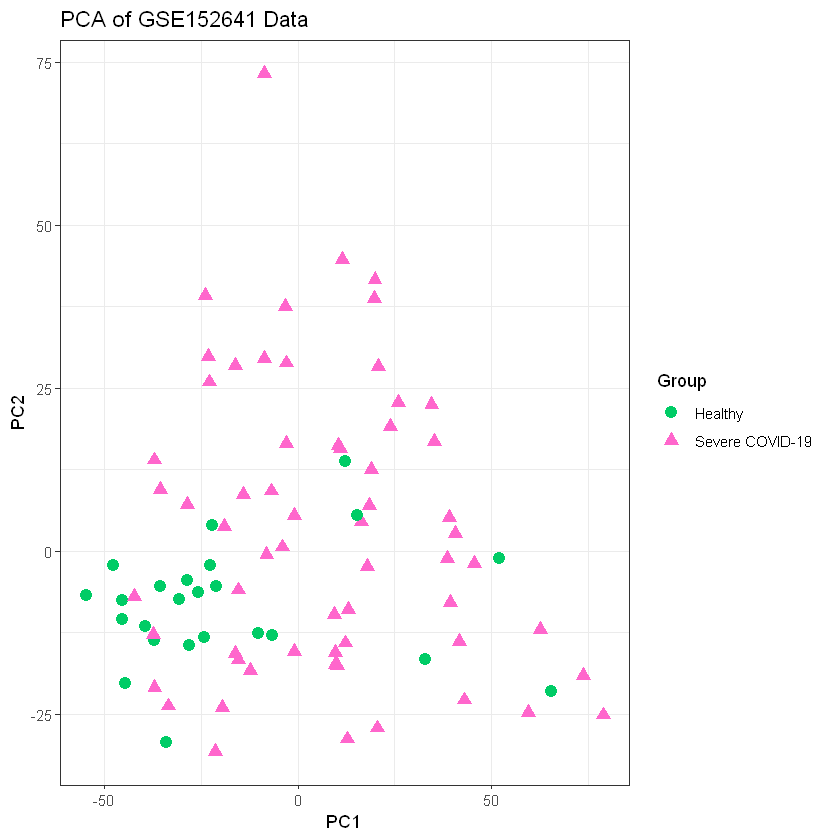

In [4]:

# Combine the data as per your instructions
print(dim(data)) 
odata0 <- cbind(data[, 1:18], data[, 81:86])  # 18 + 6 = 24 columns  -> Healthy
odata <- cbind(odata0, data[, 19:80])         # 24 + 62 = 86 columns  -> Severe COVID-19
rownames(odata) <- rownames(data)

# dimensions of odata
print(dim(odata))  # This should print 20460 x 86

# Prepare metadata with the correct number of samples
metadata2 <- data.frame(
  sampleName = colnames(odata),
  group = c(rep("disease_Healthy_control", 18), rep("disease_COVID19", 62), rep("disease_Healthy_control", 6))
)

# Checking if the metadata matches the data dimensions
print(dim(metadata2))  # This should print 86 x 2
print(length(colnames(odata)))  # This should print 86
print(length(metadata2$group))  # This should print 86

# Normalizing the counts using DESeq2's varianceStabilizingTransformation
dds <- DESeqDataSetFromMatrix(countData = odata, colData = metadata2, design = ~ group)
vsd <- varianceStabilizingTransformation(dds)

# Performing PCA
pca_result <- prcomp(t(assay(vsd)))
pc_scores <- as.data.frame(pca_result$x)
pc_scores$sampleName <- rownames(pc_scores)
pc_scores <- merge(pc_scores, metadata2, by.x = "sampleName", by.y = "sampleName")

label_mapping <- c(  "disease_COVID19" = "Severe COVID-19",  "disease_Healthy_control" = "Healthy")

#  mapping to the pc_scores dataframe
pc_scores$group <- factor(pc_scores$group, levels = names(label_mapping))
pc_scores$group <- label_mapping[pc_scores$group]

# shapes and colors
shape_values <- c("Severe COVID-19" = 17, "Healthy" = 19)
color_values <- c("Severe COVID-19" = "#FF66CC", "Healthy" = "#00CC66")

# Plot PCA 
pca_plot <- ggplot(pc_scores, aes(PC1, PC2, shape = group, color = group)) +
  geom_point(size = 3) +
  scale_shape_manual(values = shape_values) +
  scale_color_manual(values = color_values) +
  theme_bw() +
  labs(title = "PCA of GSE152641 Data", shape = "Group", color = "Group")
print(pca_plot)

# Saving the plot as PNG
#ggsave("pca_plot.png", pca_plot, width = 8, height = 6, dpi = 300)


** Differntial Expression Analysis using DESeq2 **

In [6]:
samples <- colnames(odata)
condition <- c(as.factor(rep("Healthy", 24)), as.factor(rep("Patient", 62)))
colData <- data.frame(row.names=samples, condition=condition)
dds <- DESeqDataSetFromMatrix(countData = odata, colData = colData, design = ~ condition)
dds <- DESeq(dds)
res <- results(dds)
summary(as.data.frame(res))
fres<-as.data.frame(res)
#write.table(fres, file = "DESeq2 All results.txt", sep = "\t", row.names = TRUE, quote = FALSE)

    baseMean        log2FoldChange        lfcSE             stat        
 Min.   :     0.0   Min.   :-3.5265   Min.   :0.0314   Min.   :-9.3816  
 1st Qu.:     6.5   1st Qu.:-0.1228   1st Qu.:0.0954   1st Qu.:-0.9939  
 Median :    76.7   Median : 0.1803   Median :0.1548   Median : 0.9974  
 Mean   :   636.0   Mean   : 0.3388   Mean   :0.3023   Mean   : 0.8736  
 3rd Qu.:   439.1   3rd Qu.: 0.7118   3rd Qu.:0.3559   3rd Qu.: 2.7340  
 Max.   :384339.3   Max.   : 4.4012   Max.   :3.2535   Max.   :12.7826  
                    NA's   :326       NA's   :326      NA's   :326      
     pvalue            padj       
 Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0007   1st Qu.:0.0029  
 Median :0.0371   Median :0.0742  
 Mean   :0.2014   Mean   :0.2435  
 3rd Qu.:0.3189   3rd Qu.:0.4252  
 Max.   :1.0000   Max.   :1.0000  
 NA's   :326      NA's   :326     

In [7]:
# Subset for genes with adjusted p-value < 0.05 and absolute fold change > 2
significant_genes <- subset(fres, padj < 0.05 & abs(log2FoldChange) > log2(2))
num_significant_genes <- nrow(significant_genes)
num_significant_genes
# For genes with fold change > 1
upregulated_genes <- subset(fres, padj < 0.05 & log2FoldChange > log2(2))
num_upregulated_genes <- nrow(upregulated_genes)
# For genes with fold change < -1
downregulated_genes <- subset(fres, padj < 0.05 & log2FoldChange < -log2(2))
num_downregulated_genes <- nrow(downregulated_genes)
num_upregulated_genes
num_downregulated_genes


[1] 2775

[1] 2625

[1] 150

In [ ]:
# volcano plot

# dataframe for plotting
volcano_data <- data.frame(
  logFC = fres$log2FoldChange,
  minusLog10P = -log10(fres$padj))

# Adding a significance column based on FDR and logFC
volcano_data$significant <- ifelse(fres$padj < 0.05 & abs(fres$log2FoldChange) > 1, "yes", "no")

volcano_plot <- ggplot(volcano_data, aes(x = logFC, y = minusLog10P, color = significant)) +
  geom_point(alpha = 0.5) +
  labs(title = "Volcano Plot",
       x = "Log2 Fold Change",
       y = "-Log10 P-value") +
  scale_color_manual(values = c("no" = "grey", "yes" = "red")) +  # change color as per preference
  theme_minimal()

ggsave("volcano_plot.png", plot = volcano_plot, width = 8, height = 6, units = "in", dpi = 300)


** Differntial Expression Analysis using EdgeR **

In [9]:

#  DGE object from ldata
y <- DGEList(counts=odata)
# Filter out genes with low counts
keep <- rowSums(cpm(y) > 1) >= 2
y <- y[keep, , keep.lib.sizes=FALSE]
#  TMM normalization
y <- calcNormFactors(y, method="TMM")
#  design matrix
group <- factor(c(rep("Healthy", 24), rep("Patient", 62)))
design <- model.matrix(~group)
#  dispersions
y <- estimateDisp(y, design)
# exact test for differential expression
fit <- glmQLFit(y, design)
qlf <- glmQLFTest(fit, coef=2)
results <- topTags(qlf)
print(results)
# Extracting all the differentially expressed genes
all_results <- topTags(qlf, n=Inf)  # Setting n=Inf extracts all results
sig_results <- all_results[all_results$table$FDR < 0.05, ]
write.csv(sig_results, "DEG_sig_results_FDR_less_than_0.05.csv", row.names = TRUE)
print("nrow of data")
dim(data)
print("nrow of results after 0.05 FDR cutoff")
dim(sig_results)
# Apply Foldchange cutoffs
results_df <- sig_results@.Data[[1]]
# Apply cutoffs
filtered_DEGs <- results_df[results_df$FDR < 0.05 & abs(results_df$logFC) > 1, ]
print("nrow of results after foldchange cutoff")
nrow(filtered_DEGs)

#Apply cutoff 0.01
filtered_DEGs0.01 <- results_df[results_df$FDR < 0.01 & abs(results_df$logFC) > 1, ]
print("nrow of results after foldchange cutoff and 0.01 FDR")
nrow(filtered_DEGs0.01)

upregulated_genes_0.05 <- nrow(filtered_DEGs[filtered_DEGs$logFC > 1, ])
downregulated_genes_0.05 <- nrow(filtered_DEGs[filtered_DEGs$logFC < -1, ])
print(paste("Number of significantly upregulated genes (FDR < 0.05):", upregulated_genes_0.05))
print(paste("Number of significantly downregulated genes (FDR < 0.05):", downregulated_genes_0.05))

#write results
write.table(all_results, file = "EdgR All results.txt", sep = "\t", row.names = TRUE, quote = FALSE)

Coefficient:  groupPatient 
            logFC   logCPM         F       PValue          FDR
10721   1.4950018 3.255046 135.97383 1.053474e-19 1.870338e-15
990     1.9345817 2.603980 104.69342 9.168526e-17 4.459916e-13
57326  -0.9188446 7.200877 104.13976 1.043629e-16 4.459916e-13
7259   -0.5455776 5.671108 103.65973 1.168004e-16 4.459916e-13
7280   -3.5527662 4.366688 102.81140 1.426133e-16 4.459916e-13
8344    2.1891814 5.621926 102.57707 1.507238e-16 4.459916e-13
63967   1.2329793 3.616668  99.14571 3.414913e-16 8.661194e-13
4907   -1.2345891 3.442075  94.15848 1.152105e-15 2.556809e-12
157313  1.8027707 2.251891  93.04708 1.517623e-15 2.993764e-12
116447 -1.1300972 3.907566  85.67694 9.862772e-15 1.751037e-11
[1] "nrow of data"


[1] 20460    86

[1] "nrow of results after 0.05 FDR cutoff"


[1] 8493    5

[1] "nrow of results after foldchange cutoff"


[1] 2132

[1] "nrow of results after foldchange cutoff and 0.01 FDR"


[1] 1572

[1] "Number of significantly upregulated genes (FDR < 0.05): 1951"
[1] "Number of significantly downregulated genes (FDR < 0.05): 181"


In [26]:
#intersect DESeq2 & EdgeR
inr<-intersect(rownames(significant_genes),rownames(filtered_DEGs))
inr0.01<-intersect(rownames(significant_genes0.01),rownames(filtered_DEGs0.01))
print("significant_genes")
dim(significant_genes)
print("filtered_DEGs")
dim(filtered_DEGs)
print("length(inr)")
length(inr)
write.table(inr, file = "0.05intersect.txt", sep = ",",row.name=F,quote = FALSE)
print("significant_genes0.01")
dim(significant_genes0.01)
print("filtered_DEGs0.01")
dim(filtered_DEGs0.01)
print("length of intersect0.01")
length(inr0.01)
write.table(inr0.01, file = "0.01intersect.txt", sep = ",",row.name=F,quote = FALSE)

[1] "significant_genes"


[1] 2775    6

[1] "filtered_DEGs"


[1] 2132    5

[1] "length(inr)"


[1] 2059

[1] "significant_genes0.01"


[1] 2083    6

[1] "filtered_DEGs0.01"


[1] 1572    5

[1] "length of intersect0.01"


[1] 1507